<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/analysis/analysis_userdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## User Data Store の分析
- 2023-04-04 時点のdynamodbをexport

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q awscli
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import gzip
import shutil
import glob
import json
import pandas as pd
import plotly.express as px

In [4]:
config_path = "/content/drive/MyDrive/z-gard/aws_config/awscli.ini"
!export AWS_SHARED_CREDENTIALS_FILE=$config_path
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = config_path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

/content/drive/MyDrive/z-gard/aws_config/awscli.ini


In [5]:
DIR_NAME = '/content/drive/MyDrive/z-gard/'

In [6]:
EXPORT_DATE = '20230404'
EXPORT_DIR = os.path.join(DIR_NAME, f'dynamodb_export/{EXPORT_DATE}')
os.makedirs(EXPORT_DIR, exist_ok=True)

In [7]:
source_s3 = 's3://tokyo-story-user-data/AWSDynamoDB/01680607520047-3f9f7dcb/data/'

!aws s3 cp $source_s3 $EXPORT_DIR --recursive

download: s3://tokyo-story-user-data/AWSDynamoDB/01680607520047-3f9f7dcb/data/wqibx5n5m47uzjyehvllah4xka.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230404/wqibx5n5m47uzjyehvllah4xka.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01680607520047-3f9f7dcb/data/cwzuqcrvce6ubmt5dz5ejvrs7e.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230404/cwzuqcrvce6ubmt5dz5ejvrs7e.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01680607520047-3f9f7dcb/data/o24chzv7qu2ihalt5zz2abfgxy.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230404/o24chzv7qu2ihalt5zz2abfgxy.json.gz
download: s3://tokyo-story-user-data/AWSDynamoDB/01680607520047-3f9f7dcb/data/ypcuwsget46odn73exhfxsbxxq.json.gz to drive/MyDrive/z-gard/dynamodb_export/20230404/ypcuwsget46odn73exhfxsbxxq.json.gz


In [31]:
gzfile_list = glob.glob(os.path.join(EXPORT_DIR, '*.json.gz'))
print(len(gzfile_list))

4


In [9]:
for gzfile in gzfile_list:
    target_file = os.path.join(EXPORT_DIR, os.path.basename(gzfile)[:-3])
    with gzip.open(gzfile, mode="rb") as gzip_file:
        with open(target_file, mode="wb") as decompressed_file:
            shutil.copyfileobj(gzip_file, decompressed_file)

In [32]:
json_list = glob.glob(os.path.join(EXPORT_DIR, '*.json'))
print(len(json_list))

4


In [11]:
json_file_read = []
for json_file in json_list:
    with open(json_file) as f:
        json_file_read += f.readlines()

print(len(json_file_read))

8728


In [12]:
db_contents = []
for line in json_file_read:
    db_contents.append(json.loads(line)['Item'])

In [89]:
df_db_contents = pd.DataFrame(db_contents)
print(df_db_contents.shape)

(8728, 5)


In [90]:
def get_contents(x):
    if x.get('S') is not None:
        return x['S']
    elif x.get('N') is not None:
        return float(x['N'])
    elif x.get('L') is not None:
        _list = list(x['L'])
        output = []
        for item in _list:
            output.append(get_contents(item))
        return output
    elif x.get('M') is not None:
        _dict = dict(x['M'])
        output = {}
        for k, v in _dict.items():
            output[k] = get_contents(v)
        return output
    else:
        return x

In [91]:
df_db_contents['user_id'] = df_db_contents['user_id'].apply(get_contents)
df_db_contents['datetime'] = pd.to_datetime(df_db_contents['datetime'].apply(get_contents), format='%Y-%m-%dT%H:%M:%S.%f%z')
df_db_contents['date'] = df_db_contents['datetime'].dt.date

In [92]:
df_db_contents['questions'] = df_db_contents['questions'].apply(get_contents)
df_db_contents['ranking'] = df_db_contents['ranking'].apply(get_contents).apply(lambda x: x.get('items'))
df_db_contents['details'] = df_db_contents['details'].apply(get_contents)

df_db_contents['questions_count'] = df_db_contents['questions'].apply(lambda x: len(x))
df_db_contents['ranking_count'] = df_db_contents['ranking'].apply(lambda x: 0 if x is None else len(x))
df_db_contents['details_count'] = df_db_contents['details'].apply(lambda x: len(x))

In [134]:
df_db_contents['question_cat'] = ''
df_db_contents.loc[df_db_contents['questions_count'] < 18, 'question_cat'] = '1~17'
df_db_contents.loc[df_db_contents['questions_count'] == 0, 'question_cat'] = '0'
df_db_contents.loc[df_db_contents['questions_count'] >= 18, 'question_cat'] = '18~23'

In [135]:
df_db_contents['details_cat'] = ''
df_db_contents.loc[df_db_contents['details_count'] <= 5, 'details_cat'] = df_db_contents['details_count'].astype(str)
df_db_contents.loc[df_db_contents['details_count'] > 5, 'details_cat'] = '> 5'

In [136]:
df_db_contents.head()

,user_id,datetime,questions,details,ranking,date,questions_count,ranking_count,details_count,details_cat,question_cat
0,134d54c370d5495b8ea16b50d005960d,2023-03-10 07:40:09.436666+09:00,"{'annual_income': ['3000'], 'child_age': ['未就学...",{},"[{'rank': 1.0, 'ward_name': '品川区', 'nearest_st...",2023-03-10,23,10,0,0,18~23
1,8a56d8986bf8250c8d0e20b8bf5af7c2,2023-03-09 00:03:05.070759+09:00,{},{},None,2023-03-09,0,0,0,0,0
2,39001b4e8f5bbbf4336bb4a504d24087,2023-03-08 23:47:29.672502+09:00,"{'annual_income': ['800'], 'circumstance': ['商...","{'102065': {'copyright': '©中央区(仮)', 'latitude'...","[{'rank': 1.0, 'ward_name': '板橋区', 'nearest_st...",2023-03-08,18,10,5,5,18~23
3,0ef78edfa35c5d0e4360b94a0aa34c80,2023-03-09 23:26:49.222925+09:00,"{'annual_income': ['800'], 'circumstance': ['駅...","{'116047': {'copyright': '©豊島区(仮)', 'latitude'...","[{'rank': 1.0, 'ward_name': '豊島区', 'nearest_st...",2023-03-09,18,10,1,1,18~23
4,bf902a7d26e03de36f008928cfb6d5a2,2023-03-31 14:33:37.695334+09:00,"{'annual_income': ['800'], 'circumstance': ['公...",{'116006': {'copyright': '豊島区PRキャラクター「としま ななまる...,"[{'rank': 1.0, 'ward_name': '豊島区', 'nearest_st...",2023-03-31,18,10,1,1,18~23


### 正式リリースした2023-03-08以降のデータ

In [137]:
df_after_release = df_db_contents[df_db_contents['datetime'] >= '2023-03-08']
print(df_after_release.shape)

(8233, 11)


### 使用者数の推移

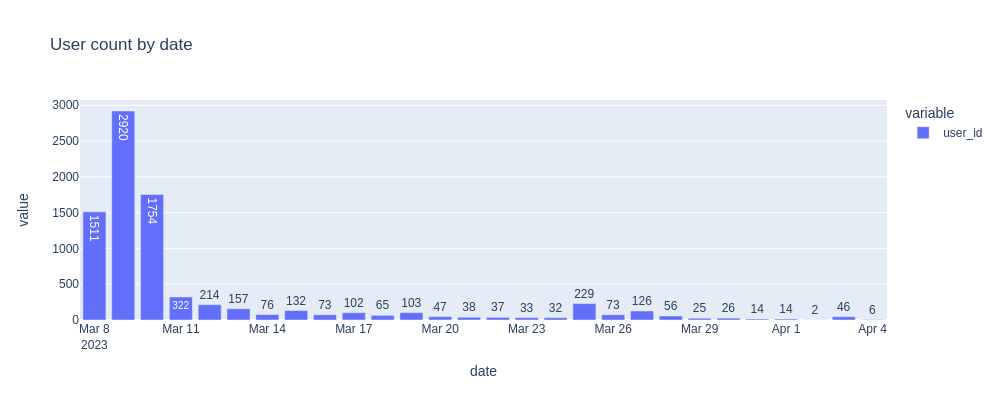

In [138]:
fig = px.bar(
    df_after_release.groupby('date')['user_id'].count(),
    text_auto=True,
    title='User count by date'
)
fig.show(renderer='png', width=1000, height=400)

### 質問回答数

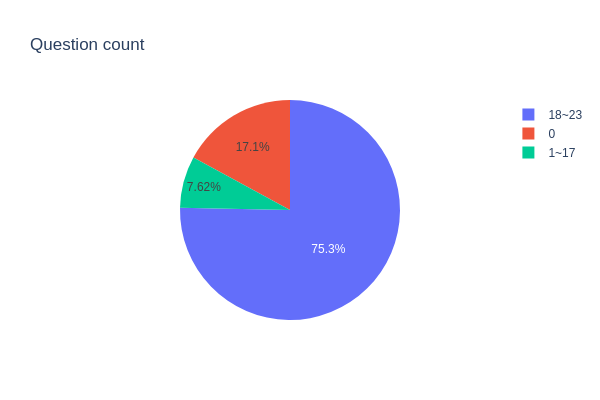

In [139]:
fig = px.pie(
    df_after_release,
    names='question_cat',
    title='Question count'
)
fig.show(renderer='png', width=600, height=400)

### ランキング
- 質問に1回以上回答したユーザー内で、ランキングの町の数
- 通常は10 (回答内容によっては10未満の場合もあり得る)
- 0は、ランキング表示まで至らなかったユーザー数

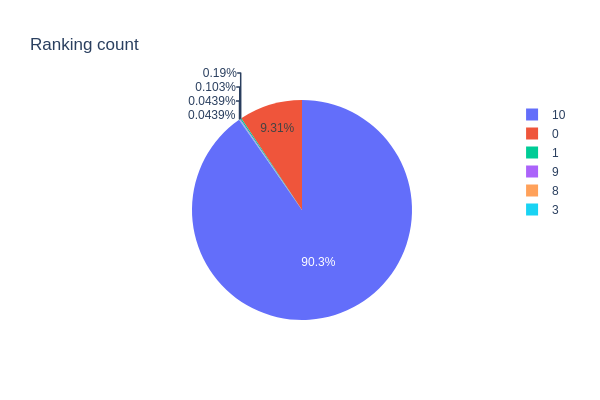

In [143]:
fig = px.pie(
    df_after_release[df_after_release['questions_count'] > 0],
    names='ranking_count',
    title='Ranking count'
)
fig.show(renderer='png', width=600, height=400)

### 町詳細画面の表示数
- ランキングを表示したユーザー内で、町詳細画面を表示した数
- 0は、ランキングだけ見て、町詳細は見なかったユーザー

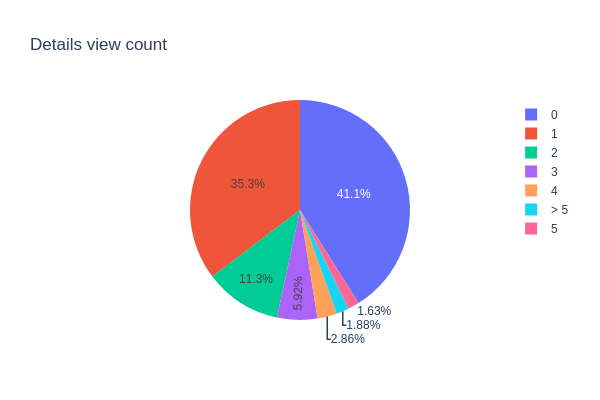

In [142]:
fig = px.pie(
    df_after_release[df_after_release['ranking_count'] > 0],
    names='details_cat',
    title='Details view count'
)
fig.show(renderer='png', width=600, height=400)